### Review of Black Litterman Model & a Variant

이 절에서는 Black Litterman Model의 두 가지 버전에 대한 번개 같은 검토를 제시한다. Black Litterman Model에 대한 검토는 전혀 포괄적이지 않으며 독자들은 참고 문헌에서 더 정교한 검토를 찾을 수 있다. 첫 번째 섹션에서는 Black & Litterman의 원래 제안에 대해 논의하고 두 번째 섹션에서는 Meucci가 제안한 변형에 대해 논의한다. 두 모델은 투자자가 자신의 견해를 통합하고자 하는 방식에 차이가 있다. 원래 Black Litterman Model에서 투자자는 자산의 선형 조합의 expected drift(또는 특정 포트폴리오의 drift)에 대한 견해를 지정한다. 그 후 Meucci는 Drift 대신 자산 수익률에 Prior 믿음과 투자자 견해가 직접 지정되는 모델의 사소한 수정을 제안했다. 실제로 이 두 가지 접근 방식은 성과 특성이 다른 매우 다른 포트폴리오를 산출한다.
이 글에서는 기존의 Black and Litterman이 제안한 원래의 모델을 BL Model-I로, Meucci가 논의한 변형을 BL Model-II로 언급할 것이다. 이제 이 두 모델에 대한 검토를 제시할 것이다.

#### 1. Original Black Litterman Model

BL Model-I에 대한 자세한 논의는 여기까지 진행하겠지만 BL Model-I의 가정과 그 기본 가정과 관련된 모델의 측면을 검토할 가치가 있다.



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

def plot_contours(
        prior_mean, 
        views_mean, 
        confidence_levels, 
        cov = [[1, 0.5], [0.5, 1]]
    ):
    x, y = np.mgrid[-2.5:2.5:.01, -2.5:2.5:.01]
    pos = np.dstack((x, y))
    prior = multivariate_normal(prior_mean, cov)
    views = multivariate_normal(views_mean, cov)
    
    fig, ax = plt.subplots(2, 3, figsize=(15, 10))
    ax = ax.ravel()

    ax[0].contour(x, y, prior.pdf(pos), colors='blue', levels=5)
    ax[0].contour(x, y, views.pdf(pos), colors='red', levels=5)
    ax[0].set_title('Prior and Views Distribution')

    for i, confidence in enumerate(confidence_levels, 1):
        updated_mean = np.array(prior_mean) * (1 - confidence) + np.array(views_mean) * confidence
        updated_dist = multivariate_normal(updated_mean, cov)
        ax[i].contour(x, y, updated_dist.pdf(pos), colors='green', levels=5)
        ax[i].set_title(f'Confidence = {int(confidence * 100)}%')
    
    plt.tight_layout()
    plt.show()

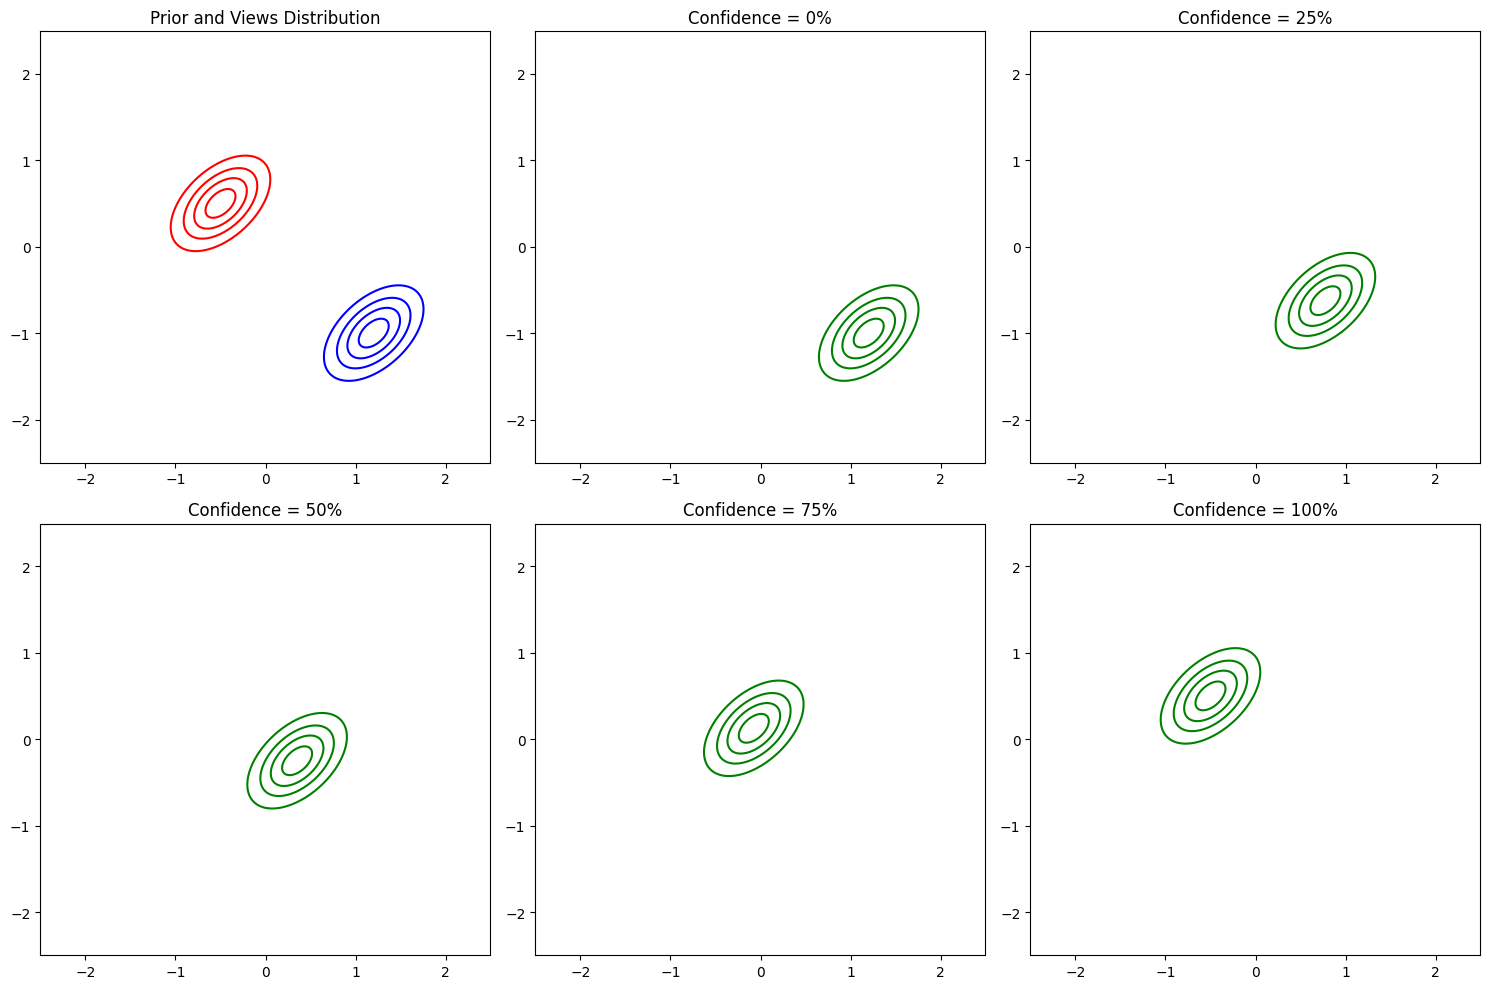

In [2]:
prior_mean = [1.2, -1]
views_mean = [-0.5, 0.5]
confidence_levels = [0, 0.25, 0.5, 0.75, 1.0]

plot_contours(
    prior_mean, 
    views_mean, 
    confidence_levels,
    cov = [
        [0.1, 0.05],
        [0.05, 0.1]
    ]
)

**Assumption 1** : 관측 가능한 자산 수익률($\vec{R}$)은 평균($\vec{\mu}R$)을 중심으로 하는 Gaussian Distribution을 따른다고 가정하고 수익률의 공분산은 $\mathscr{C}_R$로 표시한다. 수학적으로,

$$\vec{R} \sim \mathcal{N} \left( \vec{\mu}_R, \mathscr{C}_R\right), \qquad \vec{\mu}_R \in \mathbb{R}^{N_a}, \mathscr{C}_R \in \text{Sym}_{N_a}^{++}(\mathbb{R})$$

여기서 $\vec{\mu}$은 drift이고, $\mathscr{C}$는 수익률의 공분산이고, $\text{Sym}_{N_a}^{++}(\mathbb{R})$는 모든 대칭적인 실수 $N × N$ 양의 정행렬의 집합이다. 자산 수익률의 Gaussian 가정이 실제 데이터에 의해 완전히 확증되는 것은 아니지만, 수학적 편의를 제공하며, 수리 금융 문헌에서 비교적 일반적인 가정이다. $\vec{\mu}_R$과 $\mathscr{C}_R$은 관측되지 않는 양이므로 추정할 필요가 있다. 우리는 $\vec{\mu}_R$을 $\widehat{\vec{\mu}}_R$로, $\text{Cov}\left( \vec{R} \vert \widehat{\vec{\mu}}_R \right)$를 $\widehat{\mathscr{C}}_R$로 각각 추정한다. 원래 BL 모형에서 $\widehat{\vec{\mu}}_R$의 추정치는 불확실한 것으로 가정하고, 다음을 또 가정한다.

In [3]:
import yfinance as yf
import pandas as pd

TICKER = [
    'SPY', 'GLD', 'CPER', 'AGG', 'VTV', 'USO', 'IJH', 'IJR', 'QQQ'
]

data = yf.download(
    TICKER,
    start = '2020-01-01',
    progress = False,
    interval = '1d'
)['Close']

In [4]:
ret = data.pct_change().dropna()

In [5]:
num_of_asset = len(TICKER)
num_obs = len(ret)

In [6]:
true_mu = ret.mean() * 252
true_cov = ret.cov() * 252

In [7]:
R = np.random.multivariate_normal(true_mu, true_cov, num_obs)

estimated_mu_R = np.mean(R, axis=0)
estimated_cov_R = np.cov(R, rowvar=False)

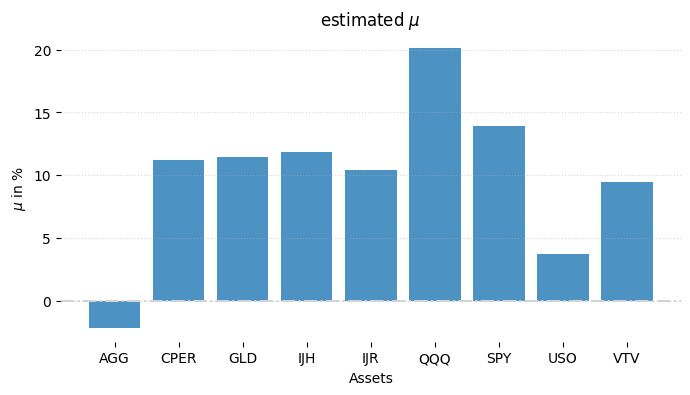

In [8]:
fig, ax = plt.subplots(figsize = (8, 4))
ax.bar(
    ret.columns,
    estimated_mu_R * 100,
    width = 0.8,
    alpha = 0.8
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.axhline(0, ls = '-.', color = 'lightgray')
plt.title(r'estimated $\mu$')
plt.xlabel('Assets')
plt.ylabel(r'$\mu$ in %')
plt.show()

In [9]:
display(
    pd.DataFrame(
        estimated_cov_R,
        index = ret.columns,
        columns = ret.columns
    )
)

Ticker,AGG,CPER,GLD,IJH,IJR,QQQ,SPY,USO,VTV
Ticker,,,,,,,,,
AGG,0.004617,0.001759,0.003845,0.003823,0.003988,0.003470,0.002977,-0.000326,0.002103
CPER,0.001759,0.060824,0.012934,0.024154,0.022509,0.021953,0.020584,0.035142,0.019037
GLD,0.003845,0.012934,0.024788,0.006939,0.006917,0.007053,0.006065,0.007472,0.005124
IJH,0.003823,0.024154,0.006939,0.072132,0.073435,0.055452,0.053907,0.036810,0.051749
IJR,0.003988,0.022509,0.006917,0.073435,0.080161,0.052729,0.052402,0.037407,0.051539
QQQ,0.003470,0.021953,0.007053,0.055452,0.052729,0.074646,0.056486,0.020841,0.041017
SPY,0.002977,0.020584,0.006065,0.053907,0.052402,0.056486,0.049511,0.027208,0.042546
USO,-0.000326,0.035142,0.007472,0.036810,0.037407,0.020841,0.027208,0.200244,0.031291
VTV,0.002103,0.019037,0.005124,0.051749,0.051539,0.041017,0.042546,0.031291,0.043616


**Assumption 2** : drift $\widehat{\vec{\mu}}_R$의 추정치는 공분산 $\mathscr{C}_d$를 갖는 정규 분포로 가정한다.

$$\widehat{\vec{\mu}}_R = \vec{\mu}_d + \vec{\epsilon}_d \qquad \text{ where  } \vec{\epsilon}_d \sim \mathcal{N} \left( \vec{0}_{N_a}, \mathscr{C}_d\right)$$

여기서 $\vec{\mu}_d \in \mathbb{R}^{N_a}$는 추정된 수익률 drift의 기대값이고, $\mathscr{C}_d \in \text{Sym}_{N_a}^{++} \left( \mathbb{R} \right)$는 추정된 수익률의 drift의 공분산이며, $\vec{0}_{N_a}$는 0벡터 또는 $\mathbb{R}^{N_a}$와 $\vec{\epsilon}_d$의 원점을 나타내며 추정의 불확실성으로 인한 불확실성을 모델링한다. 여기서 $\mathscr{C}_R \neq \widehat{\mathscr{C}}_R \equiv \text{Cov} \left( \vec{R} \vert \widehat{\mu}_R \right)$은 $\widehat{\vec{\mu}}_R$의 불확실성이 $\mathscr{C}_R$에 기여한다는 것을 주의하자. 실제로, $\mathscr{C}_R = \widehat{\mathscr{C}}_R + \mathscr{C}_d$이다.

다음 예제는 통계적으로 $\vec{\mu}_d$와 $\mathscr{C}_d$를 구하기 위한 간단한 접근법을 제공한다. 과거 표본 평균은 수익률의 drift$(\widehat{\vec{\mu}}_R)$를 단순하게 추정한 것이다. 드리프트의 다른 추정치는 표본 데이터를 resampling하여 얻은 여러 Bootstrap된 표본의 평균으로 계산할 수 있다. 이 경우 $\vec{\mu}_d$는 Bootstrap aggregated mean이고 $\mathscr{C}_d$는 drift의 공분산을 Bootstrap aggregation한 것이다. 그러나 이러한 과거 수익률을 이용한 drift 추정 방법은 투자자 견해를 통합할 수 없으며 견해가 없는 경우에도 drift 추정치로 사용하기에 불만족스러운 것으로 간주되는 경우가 많다. Black & Litterman은 투자자 특정 견해가 없는 경우(즉, 모든 투자자 견해가 동일함) drift $\vec{\mu}_d$를 추정하기 위한 논거를 제공한다. 이러한 논거는 다음 가정에서 논의될 것이다.

In [10]:
from sklearn.utils import resample

def estimate_drift_parameters(returns, n_bootstrap = 1000):
    bootstrap_means = np.array([np.mean(resample(returns), axis=0) for _ in range(n_bootstrap)])
    mu_d = np.mean(bootstrap_means, axis=0)  # Bootstrap aggregated mean
    C_d = np.cov(bootstrap_means.T) # covariance
    return mu_d, C_d

In [11]:
mu_d, cov_d = estimate_drift_parameters(ret)

In [12]:
mu_d = mu_d * 252
cov_d = cov_d * 252

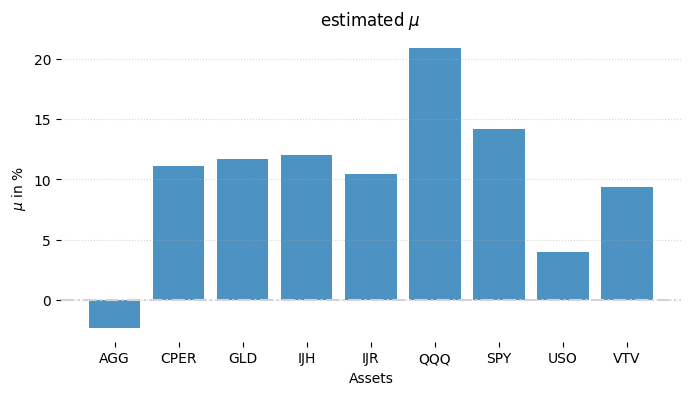

In [13]:
fig, ax = plt.subplots(figsize = (8, 4))
ax.bar(
    ret.columns,
    mu_d * 100,
    width = 0.8,
    alpha = 0.8
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.axhline(0, ls = '-.', color = 'lightgray')
plt.title(r'estimated $\mu$')
plt.xlabel('Assets')
plt.ylabel(r'$\mu$ in %')
plt.show()

In [14]:
display(
    pd.DataFrame(
        cov_d,
        index = ret.columns,
        columns = ret.columns
    )
)

Ticker,AGG,CPER,GLD,IJH,IJR,QQQ,SPY,USO,VTV
Ticker,,,,,,,,,
AGG,4.349607e-06,0.000002,0.000004,0.000003,0.000003,0.000003,0.000003,6.187405e-07,0.000002
CPER,1.824496e-06,0.000048,0.000009,0.000023,0.000023,0.000020,0.000018,2.790547e-05,0.000017
GLD,3.874178e-06,0.000009,0.000021,0.000005,0.000005,0.000005,0.000004,6.420877e-06,0.000004
IJH,3.343525e-06,0.000023,0.000005,0.000059,0.000061,0.000046,0.000045,2.841317e-05,0.000043
IJR,3.460805e-06,0.000023,0.000005,0.000061,0.000068,0.000044,0.000044,3.078101e-05,0.000044
QQQ,3.063721e-06,0.000020,0.000005,0.000046,0.000044,0.000059,0.000046,1.853989e-05,0.000035
SPY,2.558047e-06,0.000018,0.000004,0.000045,0.000044,0.000046,0.000041,2.176669e-05,0.000036
USO,6.187405e-07,0.000028,0.000006,0.000028,0.000031,0.000019,0.000022,1.663641e-04,0.000024
VTV,1.800783e-06,0.000017,0.000004,0.000043,0.000044,0.000035,0.000036,2.439891e-05,0.000037


**Assumption 3** : 모든 투자자가 동일한 견해를 가지고 있다면, 모든 투자자의 포지션은 시장(또는 관련 벤치마크 포트폴리오) 가중치 $\vec{w}_{\text{BM}}$과 일치한다. 모든 투자자가 평균 위험 회피 계수 $\gamma_R$을 사용하여 가중치를 결정하면, 아래와 같이 Markowitz 최적화 조건을 반전시켜 기준 또는 벤치마크 가중치($\vec{w}_{\text{BM}}$)로부터 expected drift $\vec{\mu}_d$를 얻는다.

$$\vec{\mu}_d = r_f \vec{e} + \gamma_R \mathscr{C}_R \vec{w}_{\text{BM}} = r_f \vec{e} + \gamma_R \left( \widehat{\mathscr{C}}_R + \mathscr{C}_d\right) \vec{w}_{\text{BM}}$$

여기서 $r_f$는 risk free rate이다. 위 식은 모든 참가자가 동일한 정보를 가지고 자산배분에 동일한 방법론을 사용하는 완전 균형 상태에 있을 때 자산 수익률의 drift를 설명하기 때문에 "균형" 모형이라고 한다. 일반적으로 공분산 행렬 $\widehat{\mathscr{C}}_R$ 및 예상 drift $\vec{\mu}_d$의 다른 추정치는 평균 분산 기반 효용 함수와 다른 reverse optimization procedure를 통해 얻을 수 있다. $\vec{\mu}_R$의 공분산이 $\vec{R}$의 조건부 공분산에 비례한다는 것으로 가정한다. 즉,

$$\mathscr{C}_d = \tau \widehat{\mathscr{C}}_R$$

여기서 $\tau$는 수많은 투자가들의 견해들로부터 받은 임의의 scalar parameter이다. $\vec{\mu}_d$의 경우 $0 \leq \tau \leq 1$은 $\widehat{\vec{\mu}}_R$ 또는 $\vec{\mu}_R$의 합리적인 추정치라는 점에 유의할 필요가 있다. 왜냐하면 기대 수익률의 평균이 수익률의 평균보다 더 정확하게 추정될 수 있기 때문이다. 만약 길이 $T$의 관측치의 표본 평균을 이용하여 균형 모형의 drift를 계산한다면, 우리는 $\tau = \frac{1}{T}$ (독립성을 가정할 때)을 가질 것이다. 균형 모형의 불확실성과 표본 추정치를 비교하는 Calibration 절차에 기초하여 $\tau$을 구한다면 $\tau \approx \frac{1}{T}$를 설정하는 것이 타당할 것으로 보인다.

In [15]:
gamma_R = 2.8 # expected risk aversion coeff
r_f = 0.052
w_BM = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1]) / 9
tau = 0.2
T = len(ret)

In [16]:
C_R_hat = cov_d
C_d = tau * C_R_hat

mu_d = r_f * np.ones_like(w_BM) + gamma_R * (C_R_hat + C_d) @ w_BM

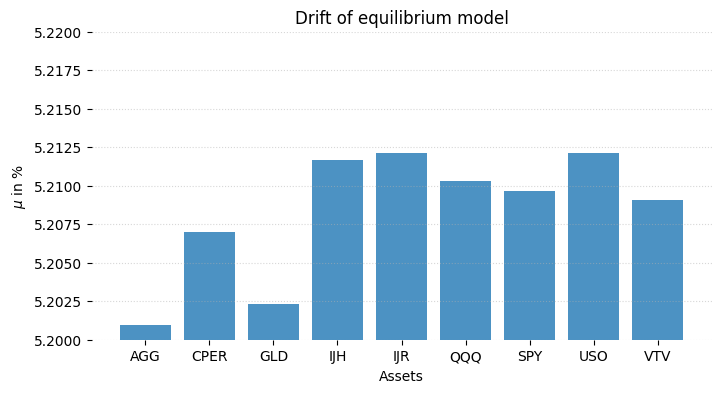

In [17]:
fig, ax = plt.subplots(figsize = (8, 4))
ax.bar(
    ret.columns,
    mu_d * 100,
    width = 0.8,
    alpha = 0.8
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.ylim([5.20, 5.22])
plt.title(r'Drift of equilibrium model')
plt.xlabel('Assets')
plt.ylabel(r'$\mu$ in %')
plt.show()

**Assumption 4** : 투자자와 전문가는 시장(또는 벤치마크)과 일치하지 않는 견해($v_d$)를 가질 수 있으며, 이를 자신의 배분 과정에 포함시키기를 원할 수 있다. 투자자는 $\mathscr{C}_{v_d}$를 지정하여 불확실성 수준도 제공해야 한다는 점에 유의한다. 보다 일반적으로 투자자는 비정상일 수 있는 기대 수익의 분포를 지정하여 전망을 지정한다. 원래 Black Litterman Model(BL Model-Ⅰ)에서 전망에 대한 분포는 Gaussian Distribution으로 가정한다. 즉, 투자자는 자산의 기대 drift(기대 수익에 대한 기대)에 대한 전망을 지정한다.

$$\mathscr{P}.\widehat{\vec{\mu}}_R = \vec{\nu}_{v_d} + \vec{\eta}_{v_d}, \qquad \text{where  } \vec{\eta}_{v_d} \sim \mathcal{N} \left( \vec{0}_{N_v}, \mathscr{C}_{v_d}\right)$$

여기서 $\mathscr{P} \in \mathbb{R}^{N_v \times N_a}$는 특정 자산 또는 자산의 일부 조합에 대한 예상 수익률을 지정하는 view matrix이며, $\vec{\nu}_{v_d} \in \mathbb{R}^{N_v}, \mathscr{C}_{v_d} \in \text{Sym}_{N_v}^{++}(\mathbb{R})$과 $N_v$는 view의 개수이다. View Matrix $\mathscr{P}$의 각 행($\vec{\mathscr{p}}_r$로 표시)은 포트폴리오 $\Pi_r$의 가중치를 나타내며 이 포트폴리오의 기대 수익에 대한 기대값은 $\nu_{v_d, r}$이다. 여기서 포트폴리오 $\Pi_r$은 Long only Portfolio가 될 수 있고(심지어는 단일 자산에 대해서도 가능하다), Long-Short Portfolio가 될 수도 있다. 원칙적으로 $\mathscr{P}$는 동일한 자산에 대해 여러 견해가 존재하기 때문에 악화될 수 있음을 유의하자. 만약 투자자의 견해들이 독립적이라면, view들과 연계된 공분산 행렬 $\mathscr{C}_{v_d}$는 대각 행렬이다. 일반적으로, view matrix $\mathscr{P}$ 및 view drift $\vec{\nu}_{v_d}$를 $\mathscr{C}_v$ 대각(diagonal)으로 변환하는 것이 가능하다. 그러나 이 Note의 목적을 위해 $\mathscr{C}_{v_d}$에 대해 어떠한 가정도 하지 않고 대칭 non-diagonal matrix가 되도록 할 것이다. 이미 view covariance matrix인 $\mathscr{C}_{v_d}$를 나타내기 위해 suffix $v_d$를 사용하여 view가 drift에 지정되어 있음을 강조했다.

In [18]:
def incorporate_views(N_a, N_v, P, nu_vd, C_vd):
    eta_vd = np.random.multivariate_normal(np.zeros(N_v), C_vd)
    adjusted_mu_R = P.T @ (nu_vd + eta_vd)
    return adjusted_mu_R

num_view = 3

Black Litterman 모델은 식 $\vec{\mu}_d = r_f \vec{e} + \gamma_R \mathscr{C}_R \vec{w}_{\text{BM}} = r_f \vec{e} + \gamma_R \left( \widehat{\mathscr{C}}_R + \mathscr{C}_d\right) \vec{w}_{\text{BM}}$에 의해 주어진 드리프트 매개변수를 사용하여 $\widehat{\vec{\mu}}_R = \vec{\mu}_d + \vec{\epsilon}_d$가 주어지고 이 글에서 $\mathbb{P} \left( \widehat{\vec{\mu}}_R \vert \mathcal{V}_d\right)$로 표시된 뷰 $\mathcal{V_d}$가 주어진 예상 수익률의 분포를 계산하여 사후 분포를 얻는 Bayesian Approach를 사용하여 view가 존재한다면 drift를 추정한다. 이제 Black Litterman Model의 주요 결과를 설명하도록 한다. 식 $\widehat{\vec{\mu}}_R = \vec{\nu}_{v_d} + \vec{\eta}_{v_d}$에서 drift에 대한 View $\mathcal{V}_d$가 주어지면 추정된 예상 수익률 $\widehat{\vec{\mu}_R}$의 업데이트된 분포 또는 Posterior distribution는 다음과 같다.

$$\mathbb{P} \left( \widehat{\vec{\mu}}_R \vert \mathcal{V}_d\right) \phi \left( \widehat{\vec{\mu}}_R ; \vec{\mu}_{\text{BL}}, \mathscr{C}_{\text{BL}}^{(\vec{\mu}_R)}\right)$$

여기서 $\phi \left( \vec{Z}; \vec{\mu}, \mathscr{C}\right)$은 Gaussian Random variable $\vec{Z} \sim \mathcal{N} \left( \vec{mu}, \mathscr{C}\right)$의 확률밀도함수이고,

$$\vec{\mu}_{\text{BL}} = \left( 
\left( \tau \widehat{\mathscr{C}}_R\right)^{-1} + \mathscr{P}^T \mathscr{C}_{v_d}^{-1}\mathscr{P}
\right)^{-1} \left( 
\left( \tau \widehat{\mathscr{C}}_R\right)^{-1} \vec{\mu}_d + \mathscr{P}^T \mathscr{C}_{v_d}^{-1}\vec{\nu}_{v_d}
\right)$$

$$
\mathscr{C}_{\text{BL}}^{(\vec{\mu}_R)} = \left( 
\left( \tau \widehat{\mathscr{C}}_R\right)^{-1} + \mathscr{P}^T \mathscr{C}_{v_d}^{-1}\mathscr{P}
\right)
$$

자산 수익률의 분포에 대한 업데이트된 추정치는 이제 다음과 같이 주어진다.

$$\mathbb{P} \left( \vec{R} \vert \mathcal{V}_d\right) = \phi \left( \vec{\mu}_{\text{BL}}, \widehat{\mathscr{C}}_{\vec{R} | v_d}\right), \qquad \text{ where  } \widehat{C}_{\vec{R} | v_d} = \widehat{\mathscr{C}}_R + \mathscr{C}_{\text{BL}}^{(\vec{\mu}_R)}$$

#### 2. A Variant of the Black-Litterman Model

Meucci(2008)에서는 전문가 견해를 기대수익률 대신에 원래의 자산 수익률에 직접적으로 표현할 수 있음을 제시하였다. Meucci는 BL Model-Ⅰ과 같이 추정된 drift에 대한 견해를 명시하는 것은 결과가 완전히 일치함에도 불구하고 제한적인 상황에서 종종 "counterintuitive"이라고 주장한다. 예를 들어, posterior distribution의 공분산은 견해가 완전히 맞는 경우뿐만 아니라 정보가 전혀 없는 경우에도 한계에서 사소한 $\tau$ 의존성을 갖는다. 이러한 $\tau$ 의존성은 추정된 drift가 불확실하다는 사실에서 비롯되며, 이는 모형 가정에 내재되어 있다.

Meucci(2008)는 보다 직관적인 제한 행동을 갖는 견해를 통합하는 대안적인 방법을 제안하였다. 이 논문에서는 BL Model-I 및 BL Model-II와 유사한 기하학적 방법을 개발하여 기하학적 방법 중 하나가 "직관적이지 않은" 결과를 산출하는지 확인할 것이다. 따라서 이 두 접근법의 기본 가정의 차이를 이해하는 것이 필수적인 것으로 보인다.

**Assumption 1** : 원래 Black-Litterman 모형에서와 같이 관측 가능한 자산 수익률($\vec{R}$)은 평균($\vec{\mu}_R$)을 중심으로 하는 Gaussian Distribution을 따른다고 가정하고 수익률의 공분산은 $\mathscr{C}_R$로 표시한다. 수학적으로,

$$\vec{R} \sim \mathcal{N}\left( \vec{\mu}_R, \mathscr{C}_R\right), \qquad \vec{\mu}_R \in \mathbb{R}^{N_a}, \mathscr{C}_R \in \text{Sym}_{N_a}^{++}(\mathbb{R})$$

이다. 기존의 Black Litterman Model과 달리 $\vec{\mu}_R = r_f \vec{e} + \gamma_R \mathscr{C}_R \vec{w}_{\text{BM}}$으로 가정하여 Random Variable로 모델링할 필요가 없다.

In [33]:
views = np.array([0.005, 0.1, 0.05, 0.2, 0.15, 0.25, 0.15, 0.1, 0.3]) # example view
confidence = np.array([0.1, 0.5, 0.3, 0.7, 0.4, 0.8, 0.2, 0.6, 0.9])

adjusted_returns = ret.copy()
for i, ticker in enumerate(ret.columns):
    adjusted_returns[ticker] += views[i] * confidence[i]

adjusted_mean = adjusted_returns.mean()
adjusted_covariance = adjusted_returns.cov()

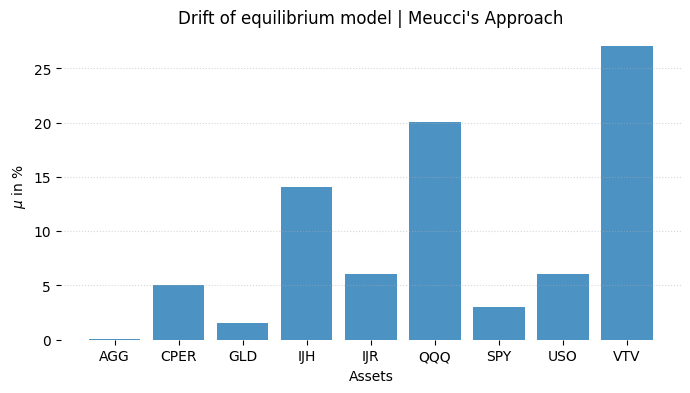

In [34]:
fig, ax = plt.subplots(figsize = (8, 4))
ax.bar(
    ret.columns,
    adjusted_mean * 100,
    width = 0.8,
    alpha = 0.8
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
#plt.ylim([5.20, 5.26])
plt.title(r"Drift of equilibrium model | Meucci's Approach")
plt.xlabel('Assets')
plt.ylabel(r'$\mu$ in %')
plt.show()

**Assumption 2** : 아래와 같이 예상수익률 대신 직접 자산수익률에 대해 전문가의 견해를 제시한다.

$$\mathscr{P}. \vec{R} = \vec{\nu}_v + \vec{\eta}_{v_R}, \qquad \text{ where  } \vec{\eta}_v \sim \mathcal{N} \left( \vec{0}_{N_v}, \mathscr{C}_{v_R}\right)$$

View covariance matirx를 나타내기 위해 suffix $\mathcal{V}_R$을 사용하여 View가 자산 수익률에 직접 지정되어 있음을 강조했다. 이 변형된 Black Litterman 모형에서는 아래와 같이 수익률의 분포가 갱신된다.

$$\mathbb{P} \left( \vec{R} \vert \mathcal{V}_R\right) = \phi \left( \vec{\mu}_{\text{BL}^\prime}^{(\vec{R})}, \mathscr{C}_{\text{BL}^\prime}^{(\vec{R})}\right)$$

여기서

$$\vec{\mu}_{\text{BL}^\prime}^{(\vec{R})} = \left( 
\widehat{\mathscr{C}}_{R}^{-1} + \mathscr{P}^T \mathscr{C}_{v_R}^{-1} \mathscr{P}
\right)^{-1} \left( 
\widehat{\mathscr{C}}_{R}^{-1} \widehat{\vec{\mu}}_R + \mathscr{P}^T \mathscr{C}_{v_R}^{-1} \vec{\nu}_v
\right)$$

$$
\mathscr{C}_{\text{BL}^\prime}^{(\vec{R})} = \left( 
\widehat{\mathscr{C}}_R^{-1} + \mathscr{P}^T \mathscr{C}_{v_R}^{-1} \mathscr{P}
\right)^{-1}
$$

여기서 $\widehat{\mathscr{C}}_R$은 수익률($\mathscr{C}_R$)의 공분산에 대한 추정치이고 $\vec{\vec{\mu}}_R$은 어떤 견해를 통합하기 전에 자산의 기대수익률에 대한 추정치이다. 위의 결과는 업데이트가 Black-Litterman 모형에서 도출되는 것과 동일한 방식으로 얻을 수 있다. 이 모형에서는 모수 $\tau$가 나타나지 않는다는 점에 유의한다. 이 도출에 대한 자세한 내용은 Meucci(2008)에서 확인할 수 있다.

In [35]:
P = np.eye(len(TICKER))

view_returns = views 
confidence_diag = np.diag(confidence)
C_vR = np.linalg.inv(confidence_diag) 
C_R_hat = ret.cov() * 252

C_R_hat_inv = np.linalg.inv(C_R_hat)
updated_covariance = np.linalg.inv(C_R_hat_inv + P.T @ np.linalg.inv(C_vR) @ P)
updated_mean = updated_covariance @ (C_R_hat_inv @ (ret.mean() * 252).values + P.T @ np.linalg.inv(C_vR) @ view_returns)

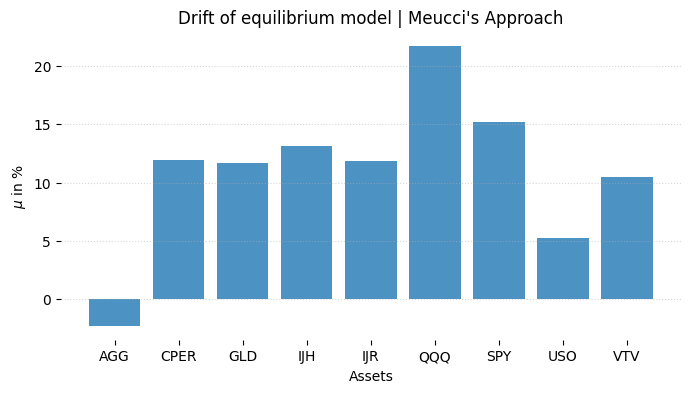

In [36]:
fig, ax = plt.subplots(figsize = (8, 4))
ax.bar(
    ret.columns,
    updated_mean * 100,
    width = 0.8,
    alpha = 0.8
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
#plt.ylim([5.20, 5.26])
plt.title(r"Drift of equilibrium model | Meucci's Approach")
plt.xlabel('Assets')
plt.ylabel(r'$\mu$ in %')
plt.show()

#### 3. A Simple Gedanken experiment

전체 투자 가능한 투자 유니버스에 단 하나의 자산 $N_a = 1$이 있다고 가정하자. 또한 투자자가 이 자산에 대한 견해를 가지고 있다고 가정하자($N_v = 1$), 이는 자산의 기대 수익률(BL Model-I에서와 같이) 또는 직접적인 자산 수익률(BL Model-II에서와 같이)에 대한 견해일 수 있다.

먼저 BL Model-I에 대한 분석을 제시할 것이다. 자산수익률($R$)의 분산 추정치를 $\hat{\sigma}_R^2$로, 자산의 기대수익률($\hat{\mu}_R$)의 분산 추정치를 $\sigma_d^2$로 나타낼 것이다. 우리가 가지고 있는 BL I model의 표기법에는 $\widehat{\mathscr{C}}_R = \widehat{\sigma}_R^2 = \text{Var}(R | \hat{\mu}_R)$ 및 $\mathscr{C}_d = \sigma_d^2 = \tau \hat{\sigma}_R^2$가 있다. Drift에 대한 투자자의 견해는 $\nu_v$로 표시하고 이에 대응하는 분산은 $\sigma_v^2$로 표시한다. BL Model-I를 사용하여 투자자의 견해를 통합한 후 업데이트된 자산의 기대수익률은 다음과 같다.

$$\mu_{\text{BL}} = \left( \frac{\sigma_{v_d}^2 \hat{\mu}_R + \sigma_d^2 \nu_{v_d}}{\sigma_{v_d}^2 + \sigma_d^2}\right) \equiv \left( \frac{\hat{\sigma}_R^2 \sigma_{v_d}^2}{\tau \hat{\sigma}_R^2 + \sigma_{v_d}^2}\right)$$

위의 결과는 단일 자산과 단일 뷰에 대한 식 $\mathbb{P} \left( \vec{R} \vert \mathcal{V}_d\right) = \phi \left( \vec{\mu}_{\text{BL}}, \widehat{\mathscr{C}}_{\vec{R} | v_d}\right)$를 직접 적용한 것이다. 식 $\mu_{\text{BL}} = \left( \frac{\sigma_{v_d}^2 \hat{\mu}_R + \sigma_d^2 \nu_{v_d}}{\sigma_{v_d}^2 + \sigma_d^2}\right) \equiv \left( \frac{\hat{\sigma}_R^2 \sigma_{v_d}^2}{\tau \hat{\sigma}_R^2 + \sigma_{v_d}^2}\right)$의 결과는 이 gedanken experiment에 충분하지만, 아래의 업데이트된 수익률 분산도 (완전성을 위해) 또한 제시하기로 한다.

$$\hat{\sigma}_{\vec{R} | v_d}^2 = \hat{\sigma}_R^2 + \sigma_{\text{BL}}^2, \qquad \text{ where  } \sigma_{\text{BL}}^2 = \tau \left( \frac{\hat{\sigma}_R^2 \sigma_{v_d}^2}{\tau \hat{\sigma}_R^2 + \sigma_{v_d}^2}\right)$$

$\mathcal{N} \left( \mu_{\text{ML}}, \sigma_{\text{BL}}^2\right)$은 기대 자산 수익률(drift)의 업데이트된 분포이고, $\mathcal{N} \left( \mu_{\text{ML}}, \sigma_{\vec{R}|v_d}^2\right)$은 자산 수익률의 업데이트된 분포임을 기억하자. 이제 우리는 이 gedanken experiment의 주요 결과를 제시할 것이다.

투자자가 자신의 견해에 대해 완전히 확신한다면, 사후 분포가 투자자의 견해 분포와 일치할 것이라는 직관적인 기대가 된다. 그러나 식 $\mu_{\text{BL}} = \left( \frac{\sigma_{v_d}^2 \hat{\mu}_R + \sigma_d^2 \nu_{v_d}}{\sigma_{v_d}^2 + \sigma_d^2}\right) \equiv \left( \frac{\hat{\sigma}_R^2 \sigma_{v_d}^2}{\tau \hat{\sigma}_R^2 + \sigma_{v_d}^2}\right)$와 식 $\hat{\sigma}_{\vec{R} | v_d}^2 = \hat{\sigma}_R^2 + \sigma_{\text{BL}}^2$을 보면 BL Model-I는 $\tau \in [0,1]$ 이후로 어떤 $\tau$ 값에 대해서도 투자자의 전망에 대한 분포를 업데이트된 분포로 생성할 수 없음이 분명하다. 인위적으로 높은 $\tau$ 값을 선택하여($\tau \rightarrow \infty$) 업데이트된 분포를 견해 분포와 일치시키는 것은 $\sigma_d^2 \gg \hat{\sigma}_R^2$를 의미하므로 비논리적이다. 따라서 $\tau$를 조정하여 사후적인 견해 분포를 얻을 수 없으므로 $\tau$는 투자자의 개인적 신뢰를 지정하는 parameter가 아니다. 사실상 기대 수익률의 추정치에 대한 "error - bars"를 지정하는 parameter이다. 투자자가 불확실성 수준으로 예상 이동에 대한 견해를 제공하기 때문에 $\sigma_{v_d}^2$도 조정할 수 없다. 일부 연구 논문에서 $\tau$ 종속 요인 또는 $\tau$에 의한 $\sigma_{v_d}^2$는 균형 모형의 관측점 수에 대한 견해 생성에 사용되는 관측점 수의 비율로 정의할 수 있다. 이 경우 $\tau \rightarrow \infty$를 사용하면 견해 분포가 Direc Delta로 변환된다. 요약하면, $\tau$는 "균형" 분포와 견해 분포 사이를 보간하는 데 사용될 수 없다.

BL Model-II의 경우 위 식들을 보면 조정 가능한 모수가 존재하지 않음이 명확하다. 따라서 BL Model-II에서도 View Covariance Matrix을 준설하는 자료 없이 투자자의 View 분포를 사후로 구할 수 없다.
이 간단한 gedanken experiment의 도움으로, 우리는 BL Model-I과 BL Model-II 모두 모수나 데이터 왜곡에 대한 비논리적인 선택을 하지 않고 투자자의 관점 분포를 사후 분포로 재현할 수 없음을 입증했다. 우리는 기하학적 접근법이 투자자에게 신뢰 수준을 조정할 수 있는 유연성을 제공하여 기하학적 사후 분포가 투자자의 관점 분포와 일치함을 보여줄 것이다.


In [74]:
hat_mu_R = ret['SPY'].mean() * 252 # expected asset mean
hat_sigma_R_squared = ret['SPY'].var() * 252 # expected asset variance
sigma_d_squared = 0.01 # expected drift variance
nu_vd = 0.2 # investor's view
sigma_vd_squared = 0.03 # variance of investor view

In [75]:
tau_values = np.linspace(0.01, 1, 100)
mu_BL_values = []
sigma_BL_values = []

In [76]:
for tau in tau_values:
    sigma_d_squared = tau * hat_sigma_R_squared
    mu_BL = ((sigma_vd_squared * hat_mu_R + sigma_d_squared * nu_vd) /
             (sigma_vd_squared + sigma_d_squared))
    sigma_BL_squared = tau * ((hat_sigma_R_squared * sigma_vd_squared) /
                              (tau * hat_sigma_R_squared + sigma_vd_squared))
    
    mu_BL_values.append(mu_BL)
    sigma_BL_values.append(sigma_BL_squared)

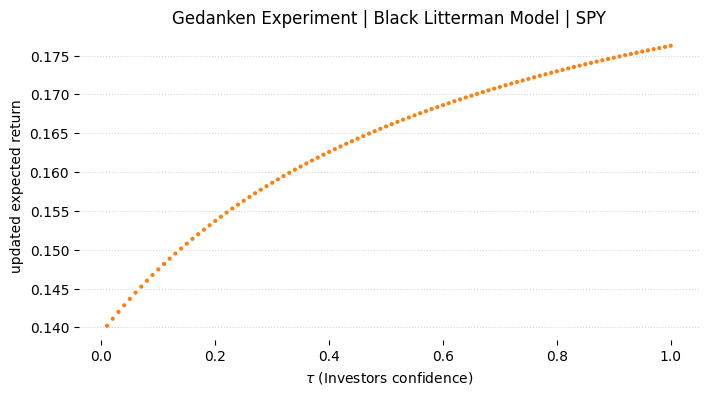

In [78]:
fig, ax = plt.subplots(figsize = (8, 4))
ax.scatter(
    tau_values, 
    mu_BL_values, 
    label = 'Updated Expected Return',
    marker = '.',
    color = 'tab:orange',
    edgecolor = 'none'
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
#plt.ylim([5.20, 5.26])
plt.title(r"Gedanken Experiment | Black Litterman Model | SPY")
plt.xlabel(r'$\tau$ (Investors confidence)')
plt.ylabel(r'updated expected return')
plt.show()